### Imports

In [17]:
from experiments.class_conditioned_alignment import class_conditioned_alignment, class_conditioned_alignment_shared
from experiments.compared_shared_encoder import compare_shared_encoder_alignment
from data.loader import get_dataloader
from models.models import SplitEncoder
from models.models import SplitDecoder
from models.models import LinearProbe, DomainProbe
from utils.aligner import finetune_entropy, finetune_entropy_detach_stabilized, finetune_entropy_detach_usps_contrastive, finetune_domain_adversary
import torch
from utils.plotting import plot_latent_tsne_before_after, plot_latent_tsne_grid
from utils.seed import set_seed

In [18]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_M = torch.load("artifacts/mnist/mnist_pretrained_usage_swap_asym.pt", map_location=device)
ckpt_U = torch.load("artifacts/usps/usps_pretrained_usage_swap_asym.pt", map_location=device)

In [20]:
input_dim = 784
output_dim = 784
latent_dim = 64
signal_dim = 32
num_classes = 10

encoder_M = SplitEncoder(input_dim=input_dim, latent_dim=latent_dim, signal_dim=signal_dim).to(device)
decoder_M = SplitDecoder(latent_dim=latent_dim, output_dim=output_dim).to(device)
probe_M = LinearProbe()

encoder_U = SplitEncoder(input_dim=input_dim, latent_dim=latent_dim, signal_dim=signal_dim).to(device)
decoder_U = SplitDecoder(latent_dim=latent_dim, output_dim=output_dim).to(device)
probe_U = LinearProbe()

In [21]:
encoder_M.load_state_dict(ckpt_M["encoder"])
decoder_M.load_state_dict(ckpt_M["decoder"])
probe_M.load_state_dict(ckpt_M["probe"])

encoder_U.load_state_dict(ckpt_U["encoder"])
decoder_U.load_state_dict(ckpt_U["decoder"])
probe_U.load_state_dict(ckpt_U["probe"])

<All keys matched successfully>

In [22]:
loader_M = get_dataloader("mnist", batch_size=256, train=False)
loader_U = get_dataloader("usps", batch_size=256, train=False)

domain_probe_M = DomainProbe(in_dim=32).to(device)
domain_probe_U = DomainProbe(in_dim=32).to(device)

### Results Prior to Finetuning on USPS

In [23]:
print("== Before finetune ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)
print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== Before finetune ==

---- MNIST to USPS ----

[Domain probe on signal] acc=65.40% | AUC=0.743
[Domain probe on nuisance] acc=63.35% | AUC=0.703
[MNIST] Var(z_s)=9.6935e-02  Var(z_n)=2.6360e-03  ‖z_s‖=1.7153  ‖z_n‖=1.7984
[USPS] Var(z_s)=4.5405e-01  Var(z_n)=2.9220e-02  ‖z_s‖=2.5632  ‖z_n‖=1.9410
Δrecon after z_n swap (mean |x−x'|) = 0.009667

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=104.5470 | MMD=0.0622
Nuisance latent           | CORAL=0.5912 | MMD=0.0177
Full latent               | CORAL=118.1416 | MMD=0.0638
Reconstruction            | CORAL=6.7486 | MMD=0.0619
Stationarized recon       | CORAL=8.1889 | MMD=0.0959


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 315.86it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=64.2534  MMD=0.5302
Class  1: CORAL=1.0718  MMD=0.7130
Class  2: CORAL=5.0532  MMD=0.2616
Class  3: CORAL=2.1416  MMD=0.1121
Class  4: CORAL=1.2950  MMD=0.3983
Class  5: CORAL=10.1082  MMD=0.2501
Class  6: CORAL=2.7917  MMD=0.7233
Class  7: CORAL=1.9773  MMD=0.6664
Class  8: CORAL=0.2154  MMD=0.0136
Class  9: CORAL=1.9150  MMD=0.7679
Avg: CORAL=9.0823  MMD=0.4436

---- USPS to MNIST ----



[Domain probe on signal] acc=83.45% | AUC=0.881
[Domain probe on nuisance] acc=72.25% | AUC=0.809
[MNIST] Var(z_s)=1.5588e-01  Var(z_n)=1.4027e-03  ‖z_s‖=2.7506  ‖z_n‖=1.7973
[USPS] Var(z_s)=4.7786e-01  Var(z_n)=1.5678e-03  ‖z_s‖=3.7494  ‖z_n‖=1.9402
Δrecon after z_n swap (mean |x−x'|) = 0.009527

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=60.3255 | MMD=0.1466
Nuisance latent           | CORAL=0.0261 | MMD=0.0236
Full latent               | CORAL=60.4786 | MMD=0.1449
Reconstruction            | CORAL=13.1704 | MMD=0.1798
Stationarized recon       | CORAL=14.6490 | MMD=0.1841


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 354.11it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=5.5724  MMD=0.5430
Class  1: CORAL=1.6035  MMD=0.4362
Class  2: CORAL=1.7592  MMD=0.1007
Class  3: CORAL=6.3075  MMD=0.6643
Class  4: CORAL=0.2450  MMD=0.0903
Class  5: CORAL=3.4456  MMD=0.2838
Class  6: CORAL=13.5263  MMD=1.1193
Class  7: CORAL=11.6882  MMD=1.0019
Class  8: CORAL=1.5705  MMD=0.4883
Class  9: CORAL=6.5217  MMD=1.1956
Avg: CORAL=5.2240  MMD=0.5923


[t-SNE] Running joint projection...


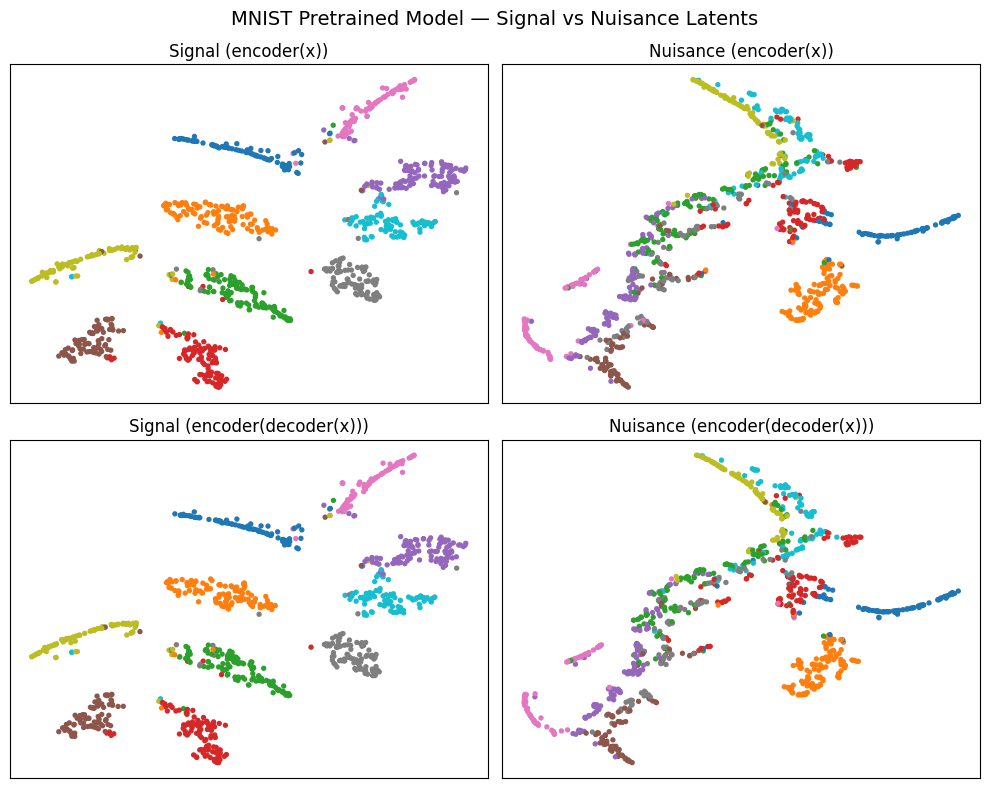

In [25]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_M,
    device=device,
    save_path=None,
    n_samples=1000,
    title_prefix="MNIST Pretrained Model"
)

[t-SNE] Running joint projection...


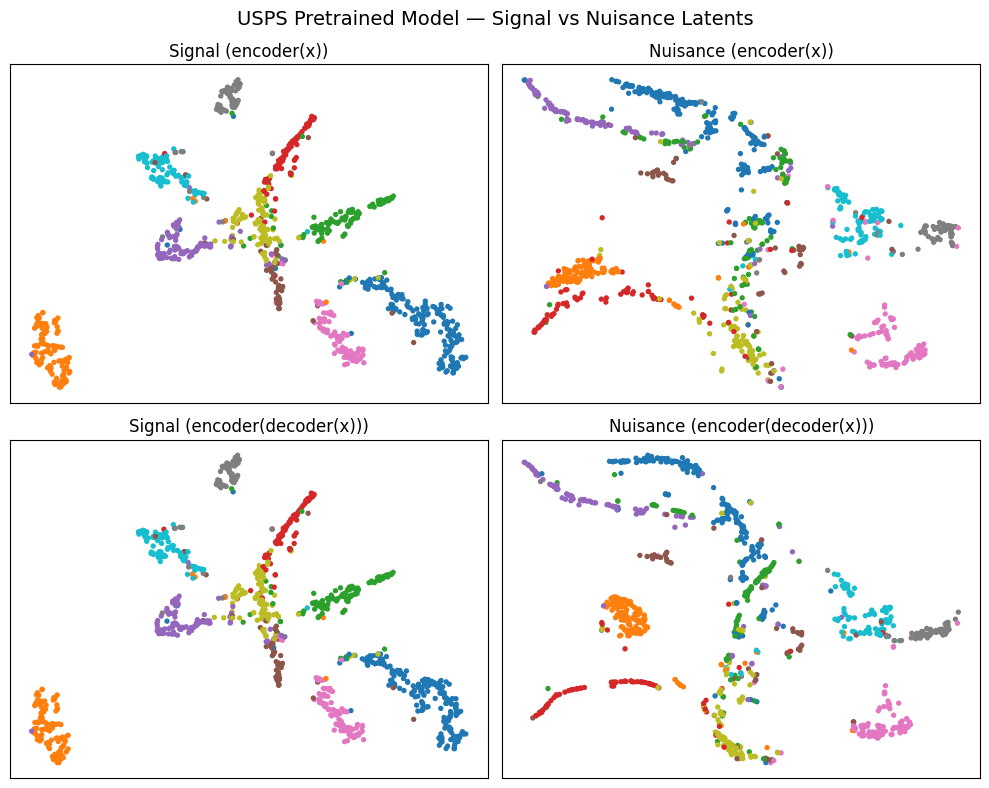

In [27]:
plot_latent_tsne_grid(
    encoder=encoder_U,
    decoder=decoder_U,
    dataloader=loader_U,
    device=device,
    save_path=None,
    n_samples=1000,
    title_prefix="USPS Pretrained Model"
)

### Step 1: Finetuning for reduce MMD and CORAL

In [28]:
print("\n -- Finetuning Step 1 MNIST encoder-decoder -- \n")
finetune_entropy_detach_stabilized(
    encoder_M, decoder_M, probe_M,
    loader_mnist=loader_M,
    loader_usps=loader_U,
    device=device,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3,
    epochs=3, lr=1e-4
)
print("\n -- Finetuning Step 1 USPS encoder-decoder -- \n")
finetune_entropy_detach_stabilized(
    encoder_U, decoder_U, probe_U,
    loader_mnist=loader_U,
    loader_usps=loader_M,
    device=device,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3,
    epochs=3, lr=1e-4
)


 -- Finetuning Step 1 MNIST encoder-decoder -- 

[Finetune Detach+Stabilized 1/3] Loss=0.7726 Cls=0.1980 Rec=0.7058 Ent=0.6809 Zvar=0.0215 Swap=1.6549
[Finetune Detach+Stabilized 2/3] Loss=0.7602 Cls=0.1914 Rec=0.7014 Ent=0.6698 Zvar=0.0216 Swap=1.6509
[Finetune Detach+Stabilized 3/3] Loss=0.7136 Cls=0.1479 Rec=0.7040 Ent=0.6556 Zvar=0.0255 Swap=1.6440

 -- Finetuning Step 1 USPS encoder-decoder -- 

[Finetune Detach+Stabilized 1/3] Loss=1.3030 Cls=0.5025 Rec=0.9181 Ent=1.0694 Zvar=0.0004 Swap=1.9376
[Finetune Detach+Stabilized 2/3] Loss=1.2601 Cls=0.4784 Rec=0.8846 Ent=1.0632 Zvar=0.0004 Swap=1.9259
[Finetune Detach+Stabilized 3/3] Loss=1.2166 Cls=0.4674 Rec=0.8675 Ent=0.9837 Zvar=0.0007 Swap=1.9158


In [29]:
print("== After finetune step 1 ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)
print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== After finetune step 1 ==

---- MNIST to USPS ----

[Domain probe on signal] acc=72.70% | AUC=0.837
[Domain probe on nuisance] acc=71.70% | AUC=0.787
[MNIST] Var(z_s)=1.1834e-01  Var(z_n)=3.1371e-03  ‖z_s‖=1.9345  ‖z_n‖=1.8681
[USPS] Var(z_s)=3.4796e-01  Var(z_n)=3.9864e-02  ‖z_s‖=2.4714  ‖z_n‖=2.1703
Δrecon after z_n swap (mean |x−x'|) = 0.009868

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=42.6241 | MMD=0.0751
Nuisance latent           | CORAL=1.0995 | MMD=0.0286
Full latent               | CORAL=53.2866 | MMD=0.0753
Reconstruction            | CORAL=2.2430 | MMD=0.0815
Stationarized recon       | CORAL=4.5021 | MMD=0.1181


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 231.39it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=32.0666  MMD=0.6000
Class  1: CORAL=1.1152  MMD=0.7343
Class  2: CORAL=3.4420  MMD=0.2390
Class  3: CORAL=1.5787  MMD=0.0915
Class  4: CORAL=1.6727  MMD=0.4137
Class  5: CORAL=5.8511  MMD=0.2306
Class  6: CORAL=2.1559  MMD=0.6364
Class  7: CORAL=3.1458  MMD=0.8248
Class  8: CORAL=0.2117  MMD=0.0239
Class  9: CORAL=3.4481  MMD=0.9524
Avg: CORAL=5.4688  MMD=0.4747

---- USPS to MNIST ----



[Domain probe on signal] acc=87.65% | AUC=0.908
[Domain probe on nuisance] acc=87.00% | AUC=0.928
[MNIST] Var(z_s)=1.9517e-01  Var(z_n)=1.2086e-03  ‖z_s‖=3.1575  ‖z_n‖=2.3516
[USPS] Var(z_s)=5.3104e-01  Var(z_n)=2.1066e-03  ‖z_s‖=3.9922  ‖z_n‖=2.3401
Δrecon after z_n swap (mean |x−x'|) = 0.004405

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=65.6608 | MMD=0.1100
Nuisance latent           | CORAL=0.0092 | MMD=0.0084
Full latent               | CORAL=65.9522 | MMD=0.1087
Reconstruction            | CORAL=11.2823 | MMD=0.1879
Stationarized recon       | CORAL=9.3610 | MMD=0.1910


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 326.55it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=6.4151  MMD=0.6094
Class  1: CORAL=1.5522  MMD=0.3406
Class  2: CORAL=1.0029  MMD=0.1216
Class  3: CORAL=6.3527  MMD=0.6559
Class  4: CORAL=0.2605  MMD=0.1176
Class  5: CORAL=3.1203  MMD=0.3527
Class  6: CORAL=10.4230  MMD=1.1540
Class  7: CORAL=9.0033  MMD=1.0018
Class  8: CORAL=1.7596  MMD=0.4948
Class  9: CORAL=5.1912  MMD=1.1360
Avg: CORAL=4.5081  MMD=0.5985


In [30]:
print("\n -- Finetuning Step 2 MNIST encoder-decoder -- \n")
finetune_entropy_detach_usps_contrastive(
    encoder_M, decoder_M, probe_M,
    loader_M, loader_U,
    device,
    domain_probe=domain_probe_M,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3, lambda_dom=0.2,
    epochs=3, lr=1e-4,
    save_path="artifacts/mnist/mnist_finetuned.pt"
)
print("\n -- Finetuning Step 2 USPS encoder-decoder -- \n")
finetune_entropy_detach_usps_contrastive(
    encoder_U, decoder_U, probe_U,
    loader_U, loader_M,
    device,
    domain_probe=domain_probe_M,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3, lambda_dom=0.2,
    epochs=3, lr=1e-4,
    save_path="artifacts/usps/usps_finetuned.pt"
)


 -- Finetuning Step 2 MNIST encoder-decoder -- 

[Finetune Detach+Contrastive 1/3] Loss=0.8458 Cls=0.1730 Rec=0.6898 Ent=0.6333 Dom=0.6895
[Finetune Detach+Contrastive 2/3] Loss=0.8498 Cls=0.1861 Rec=0.6882 Ent=0.6120 Dom=0.6802
[Finetune Detach+Contrastive 3/3] Loss=0.8018 Cls=0.1427 Rec=0.6930 Ent=0.5943 Dom=0.6714
✅ USPS finetune (detach + contrastive) saved to artifacts/mnist/mnist_finetuned.pt

 -- Finetuning Step 2 USPS encoder-decoder -- 

[Finetune Detach+Contrastive 1/3] Loss=1.3283 Cls=0.4630 Rec=0.8262 Ent=0.9682 Dom=0.8088
[Finetune Detach+Contrastive 2/3] Loss=1.3134 Cls=0.4488 Rec=0.8140 Ent=0.9893 Dom=0.8040
[Finetune Detach+Contrastive 3/3] Loss=1.2887 Cls=0.4401 Rec=0.8171 Ent=0.9340 Dom=0.7994
✅ USPS finetune (detach + contrastive) saved to artifacts/usps/usps_finetuned.pt


In [31]:
print("== After finetune step 2 ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)

print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== After finetune step 2 ==

---- MNIST to USPS ----

[Domain probe on signal] acc=70.60% | AUC=0.829
[Domain probe on nuisance] acc=74.65% | AUC=0.851
[MNIST] Var(z_s)=1.2454e-01  Var(z_n)=4.0730e-03  ‖z_s‖=1.9842  ‖z_n‖=1.9052
[USPS] Var(z_s)=3.7064e-01  Var(z_n)=7.1224e-02  ‖z_s‖=2.5796  ‖z_n‖=2.3888
Δrecon after z_n swap (mean |x−x'|) = 0.010771

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=47.5555 | MMD=0.0730
Nuisance latent           | CORAL=3.4894 | MMD=0.0493
Full latent               | CORAL=69.0124 | MMD=0.0727
Reconstruction            | CORAL=2.4108 | MMD=0.0855
Stationarized recon       | CORAL=4.4646 | MMD=0.1286


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 320.61it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=28.9897  MMD=0.6325
Class  1: CORAL=1.1951  MMD=0.7476
Class  2: CORAL=3.0851  MMD=0.2238
Class  3: CORAL=1.8448  MMD=0.0948
Class  4: CORAL=1.8319  MMD=0.4172
Class  5: CORAL=5.2114  MMD=0.2302
Class  6: CORAL=2.2602  MMD=0.6680
Class  7: CORAL=3.2656  MMD=0.8489
Class  8: CORAL=0.2586  MMD=0.0366
Class  9: CORAL=3.9725  MMD=0.9719
Avg: CORAL=5.1915  MMD=0.4872

---- USPS to MNIST ----



[Domain probe on signal] acc=89.25% | AUC=0.928
[Domain probe on nuisance] acc=86.70% | AUC=0.956
[MNIST] Var(z_s)=2.1341e-01  Var(z_n)=1.3158e-03  ‖z_s‖=3.3362  ‖z_n‖=2.8422
[USPS] Var(z_s)=5.6776e-01  Var(z_n)=4.6577e-03  ‖z_s‖=4.1423  ‖z_n‖=2.6112
Δrecon after z_n swap (mean |x−x'|) = 0.003182

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=72.6109 | MMD=0.1003
Nuisance latent           | CORAL=0.0813 | MMD=0.0557
Full latent               | CORAL=73.8846 | MMD=0.0992
Reconstruction            | CORAL=16.1384 | MMD=0.1908
Stationarized recon       | CORAL=7.9281 | MMD=0.1893


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 286.02it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=7.5206  MMD=0.6034
Class  1: CORAL=1.7510  MMD=0.3145
Class  2: CORAL=0.7863  MMD=0.1198
Class  3: CORAL=7.0143  MMD=0.6549
Class  4: CORAL=0.2702  MMD=0.1224
Class  5: CORAL=3.0481  MMD=0.3434
Class  6: CORAL=10.3252  MMD=1.0956
Class  7: CORAL=8.0812  MMD=0.9759
Class  8: CORAL=2.0574  MMD=0.4853
Class  9: CORAL=4.6722  MMD=1.0872
Avg: CORAL=4.5527  MMD=0.5802


[t-SNE] Running joint projection...


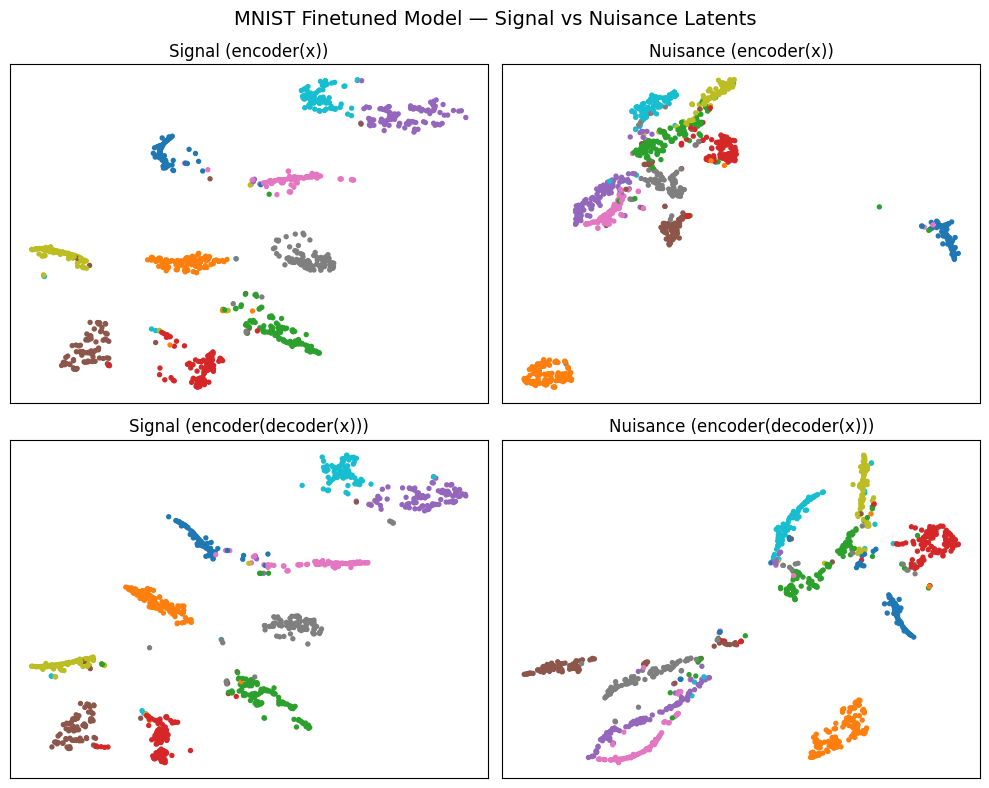

In [32]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_M,
    device=device,
    save_path=None,
    n_samples=1000,
    title_prefix="MNIST Finetuned Model"
)

In [22]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_U,
    device=device,
    save_path="artifacts/plots/mnist_usps_finetuned_latent_grid.png",
    n_samples=1000,
    title_prefix="MNIST Finetuned Model"
)

[t-SNE] Running joint projection...
✅ t-SNE plot saved to artifacts/plots/mnist_usps_finetuned_latent_grid.png
